# **SIADS Milestone II - Forecasting Federal Funds Rate Movements through Natural Language Processing of FOMC Minutes**

**s24-milestone2-team7-cspaarg-cydia-davidrez**
- **Casey Spaargaren(cspaarg@umich.edu)**, School of Information, University of Michigan
- **Cydia Tsang (cydia@umich.edu)**, School of Information, University of Michigan
- **David Rezkalla(davidrez@umich.edu)**, School of Information, University of Michigan


#### **Strcuture of the Code:**

&emsp; **Data Import**<br>
&emsp;&emsp;&emsp; Federal Reserve's meeting minutes from 2000 to 2024<br>
&emsp; **Data Cleaning & Manipulation**<br>
&emsp; **Basic Descriptive Statistic**<br>
&emsp;&emsp;&emsp; 1. Basic Desciptive Statistic Analysis<br>
&emsp; **Supervising Learning**<br>
&emsp;&emsp;&emsp; 1. Naive Bayes, Linear Regression, Support Vector Machine (SVM), and Decision Trees<br>
&emsp;&emsp;&emsp; 2. Random Forest<br>
&emsp;&emsp;&emsp; 3. Random Forest<br>
&emsp;&emsp;&emsp; 4. LSTM (Long Short-Term Memory) Networks:<br>
&emsp;&emsp;&emsp; 5. LLM Model: Bert/ Llama<br>
&emsp; **Unsupervising Learning**<br>
&emsp;&emsp;&emsp; 1. Topic Modeling (e.g., Latent Dirichlet Allocation - LDA)<br>
&emsp;&emsp;&emsp; 2. Clustering (e.g., K-Means)<br>
&emsp;&emsp;&emsp; 3. Semantic Analysis<br>
&emsp;&emsp;&emsp; 4. LSTM (Long Short-Term Memory) Networks:<br>
&emsp;&emsp;&emsp; 5. Principal Component Analysis (PCA)<br>

In [2]:
#Remeber to run the following commannd before running the following codes. Details Please refer to README.md
# !pip install -r requirements.txt

In [3]:
from bs4 import BeautifulSoup
import urllib
from time import sleep
import re,csv,os
from os import listdir
from os.path import isfile, join
import os
import glob
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

# **Data Import**

The project requires the Federal Reserve's meeting minutes from 2000 to 2024, sourced from the official Fed website at https://www.federalreserve.gov. The Federal Open Market Committee (FOMC) holds eight regularly scheduled meetings each year, with additional meetings as needed. Policy statements and minutes are linked in the calendars on the website. The minutes of regularly scheduled meetings are released three weeks after the policy decision date, and committee membership changes occur at the first meeting of each year. The retrieved data is organized and stored as individual files, named meeting_minute_YYYYMMDD.txt, in the data/output directory.

In [14]:
releaseDates = [line.rstrip() for line in open(os.path.join('data/meeting_minute/meeting_dates.csv'), 'r')]

def getFedMeetingMinutesUrl(date):
    year = date[0:4]
    dateInt = int(date)
    if dateInt <= 19951219:
        url = 'https://www.federalreserve.gov/fomc/MINUTES/' + year + '/' + date + 'min.htm'
    elif dateInt >= 19950201 and dateInt < 20070918:
        url = 'https://www.federalreserve.gov/fomc/minutes/' + date + '.htm'
    elif dateInt == 20080625:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomc20080625.htm'
    elif dateInt > 20070918:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomcminutes' + date + '.htm'
    print(url)
    return url

def getStatement(date):
    print('Pulling meeting minute of date: ' + date)
    req = urllib.request.Request(getFedMeetingMinutesUrl(date), headers={'User-Agent' : "Magic Browser"}) 
    html = urllib.request.urlopen( req ).read()
    soup = BeautifulSoup(html)
    minutesText = soup.get_text(" ")
    return minutesText

In [15]:
for releaseDate in releaseDates:
    file_path="./data/output/meeting_minute_" + releaseDate +".txt"
    if os.path.isfile(file_path) == False:
        data = getStatement(releaseDate)
        sleep(2)
    
        f = open(file_path, 'w')
        f.write(data)
        f.close

# **Data Cleaning & Manipulation***

In [17]:
# Load FOMC meeting minutes
meeting_minutes_dir = "data/output"
meeting_minutes_files = os.listdir(meeting_minutes_dir)

# Function to preprocess text (tokenize and remove stop words)
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

meeting_minutes = []
for file in meeting_minutes_files:
    file_path = os.path.join(meeting_minutes_dir, file)
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except UnicodeDecodeError:
        try:
            with open(file_path, 'r', encoding='latin-1') as f:
                text = f.read()
        except UnicodeDecodeError as e:
            print(f"Error reading {file}: {e}")
            continue

    preprocessed_text = preprocess_text(text)
    meeting_minute = {
        'meeting_minute': preprocessed_text,
        'file_date': file.replace('meeting_minute_', '').replace('.txt', '')
    }
    meeting_minutes.append(meeting_minute)

In [18]:
meeting_minutes_df = pd.DataFrame(meeting_minutes)
meeting_minutes_df.file_date = pd.to_datetime(meeting_minutes_df.file_date, format='%Y%m%d')
meeting_minutes_df = meeting_minutes_df.set_index('file_date')
meeting_minutes_df = meeting_minutes_df.sort_index()
meeting_minutes_df.head()

,meeting_minute
file_date,
1993-02-03,frb fomc minutesfebruary 23 1993 minutes feder...
1993-03-23,frb fomc minutesmarch 23 1993 minutes federal ...
1993-05-18,frb fomc minutesmay 18 1993 minutes federal op...
1993-07-07,frb fomc minutesjuly 67 1993 minutes federal o...
1993-08-17,frb fomc minutesaugust 17 1993 minutes federal...


In [6]:
# Load Federal Funds Rate data
fed_fund_rate_data = pd.read_csv("data/fed_fund_rate.csv")
fed_fund_rate_data = pd.DataFrame(fed_fund_rate_data)
fed_fund_rate_data['date'] = pd.to_datetime(fed_fund_rate_data['date'])
fed_fund_rate_data = fed_fund_rate_data.rename(columns={'value': 'rate'})
fed_fund_rate_data['diff'] =fed_fund_rate_data['rate'].diff(1)
fed_fund_rate_data['changed'] = np.where(fed_fund_rate_data['diff']!=0.0000, 1, 0)
fed_fund_rate_data = fed_fund_rate_data.set_index('date')
fed_fund_rate_data = fed_fund_rate_data.sort_index()
fed_fund_rate_data.head()

,rate,diff,changed
date,,,
1954-07-07,1.00,NaN,1
1954-07-14,1.22,0.22,1
1954-07-21,0.57,-0.65,1
1954-07-28,0.63,0.06,1
1954-08-04,0.27,-0.36,1


In [7]:
# Indicate if a rate changed within x days (try 7?) after a document is published, 
# by merging the rate and content df's
# then display what it gets us

tol = pd.Timedelta('7 day')
merge_df = pd.merge_asof(left=meeting_minutes_df,right=fed_fund_rate_data,right_index=True,left_index=True,direction='nearest',tolerance=tol)
merge_df.head()

,meeting_minute,rate,diff,changed
file_date,,,,
1993-02-03,frb fomc minutesfebruary 23 1993 minutes feder...,3.15,0.21,1
1993-03-23,frb fomc minutesmarch 23 1993 minutes federal ...,2.93,-0.11,1
1993-05-18,frb fomc minutesmay 18 1993 minutes federal op...,3.01,0.11,1
1993-07-07,frb fomc minutesjuly 67 1993 minutes federal o...,3.10,-0.03,1
1993-08-17,frb fomc minutesaugust 17 1993 minutes federal...,3.06,0.08,1


# **Basic Descriptive Statistic**

In [8]:
# TODO : Cydia

# **Machine Learning Model**

In [12]:
X = merge_df['meeting_minute'].astype(str)
y = merge_df['rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Supervising Learning** 

Linear Regression:
Mean Squared Error: 0.33261711621615975
R^2 Score: 0.9339960039164749


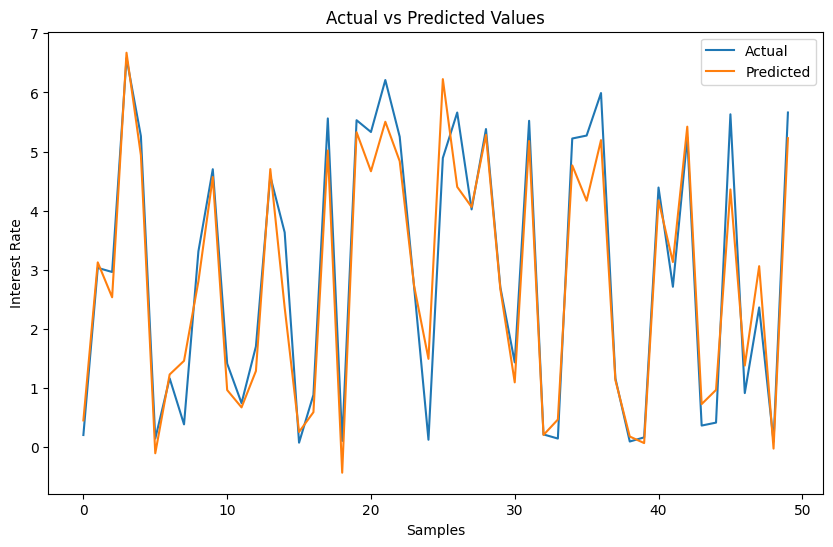


Support Vector Machine (SVM):
Mean Squared Error: 1.2512919148139092
R^2 Score: 0.7516956806544779


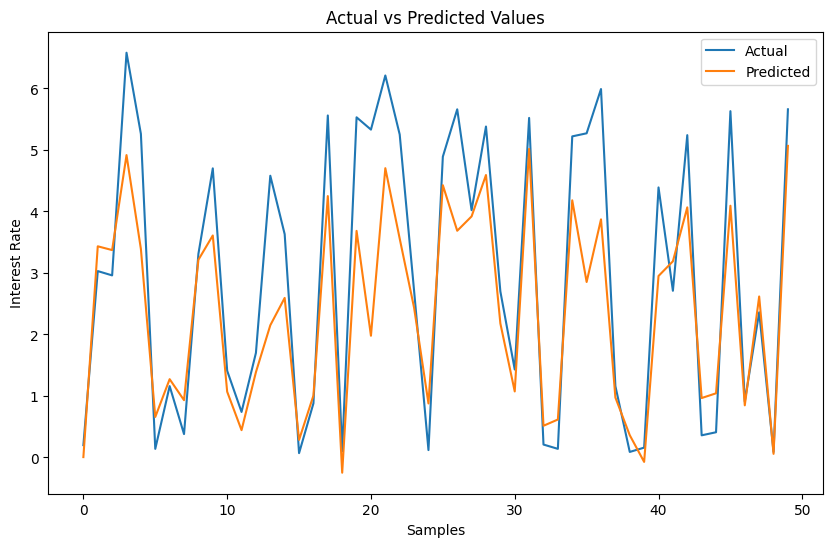


Decision Tree Regressor:
Mean Squared Error: 1.994624
R^2 Score: 0.604190078424746


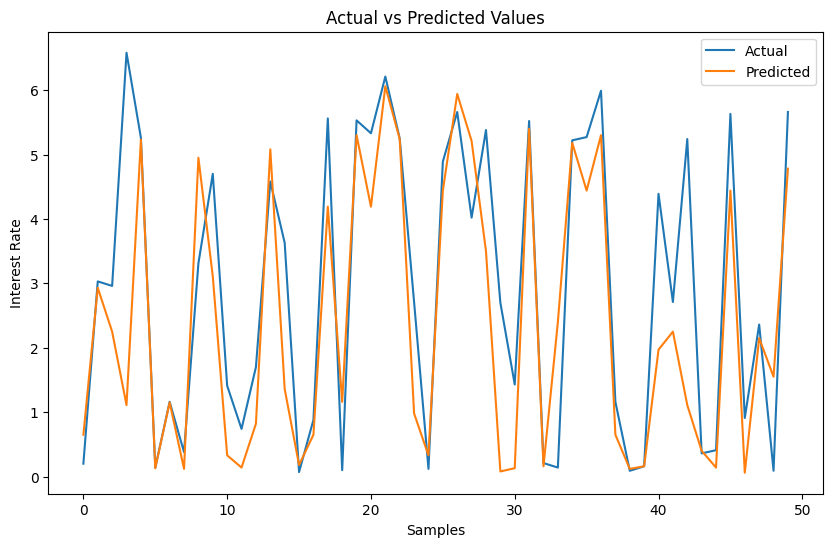

In [16]:
# Linear Regression Pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', LinearRegression())
])

# Support Vector Machine (SVM) Pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', SVR(kernel='linear'))
])

# Decision Tree Regressor Pipeline
dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', DecisionTreeRegressor(random_state=42))
])

def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
    # Plotting actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel('Interest Rate')
    plt.show()
    
    return predictions
    
print("Linear Regression:")
lr_predictions = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test)

print("\nSupport Vector Machine (SVM):")
svm_predictions = evaluate_model(svm_pipeline, X_train, X_test, y_train, y_test)

print("\nDecision Tree Regressor:")
dt_predictions = evaluate_model(dt_pipeline, X_train, X_test, y_train, y_test)


# TODO : Work on the remaining Supervising Learning or llm model - David

# **Unsupervising Learning**

In [ ]:
# TODO : David